# Week 4 Dissaster Tweet

## Part 1 Introduction

Social media is crucial during emergencies, but sifting through the noise for genuine cries for help is tough.  This competition challenges you to build a machine learning model that distinguishes between tweets reporting real disasters and those that don't.  Take, for example, this tweet: "On the plus side, LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE."  While "ablaze" suggests disaster, the image shows a beautiful sunset.  Your model needs to understand this nuance.

We'll use Natural Language Processing (NLP) to tackle this.  Success will be measured by the F1-score, balancing precision (correctly identified disasters) and recall (finding all actual disasters).  Maximize your F1-score to win!

## Part 2 Set up

This section includes the needed packages to complete this assignement

In [1]:
!pip install datasets
!pip install transformers
!pip install tf-keras
!pip install accelerate==0.26.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import re
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments
import datasets

## Part 3 Data Processing/EDA

This Section includes the setup for data processing 

In [3]:
base_dir= ("C:/Users/Kenji/OneDrive/Documents/Intro to ML/Week 4")
df_test= pd.read_csv("C:/Users/Kenji/OneDrive/Documents/Intro to ML/Week 4/Data/test.csv")
df_train= pd.read_csv("C:/Users/Kenji/OneDrive/Documents/Intro to ML/Week 4/Data/train.csv")
prtr_model = "microsoft/deberta-v3-small"

In [4]:
df_train["inputs"] = df_train["text"].apply(lambda x: x.lower())
df_train.head

<bound method NDFrame.head of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of contro

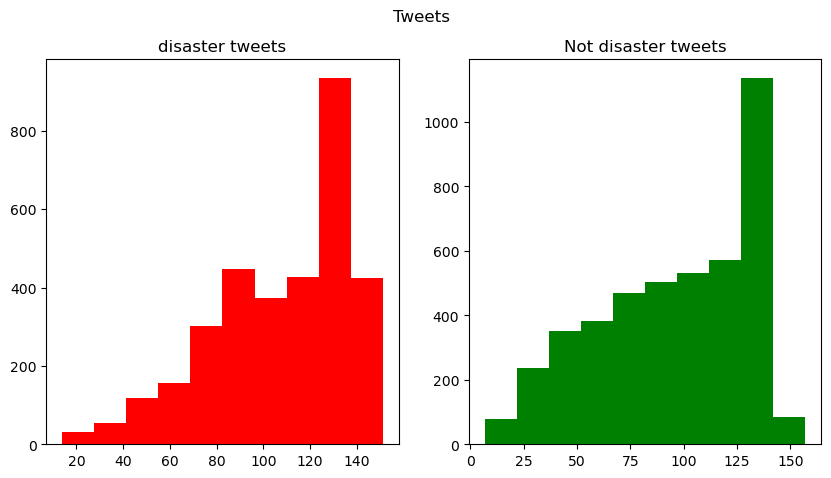

In [5]:
len_dis = df_train[df_train["target"]==1].inputs.apply(lambda x: len(x))
df_train["target"].value_counts()
len_nondis = df_train[df_train["target"]==0].inputs.apply(lambda x: len(x))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
len_dis = df_train[df_train["target"]==1].inputs.apply(lambda x: len(x))
ax1.hist(len_dis,color='red')
ax1.set_title('disaster tweets')
len_nondis = df_train[df_train["target"]==0].inputs.apply(lambda x: len(x))
ax2.hist(len_nondis,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Tweets')
plt.show()

In [6]:
def remove_urls(input_string):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    result_string = url_pattern.sub('', input_string)

    return result_string

In [7]:
url_included =" This is an import url https://support.microsoft.com/es-es/windows/c%C3%B3mo-saber-que-es-el-momento-de-un-equipo-nuevo-7be6ab00-d111-4834-bf47-123528f36994?Ocid=prod_cge_cons_win_eng_AC_NewPCTime2022&form=M7001T"
remove_urls(url_included)

' This is an import url '

In [8]:
df_train["inputs"] = df_train["inputs"].apply(lambda x: remove_urls(x))

In [9]:
length_dis = df_train[df_train["target"]==1]["inputs"].apply(lambda x: len(x))
length_nondis = df_train[df_train["target"]==0]["inputs"].apply(lambda x: len(x))


## Part 4 Model Building

In this section we are creating a model to analyze tweets. 

Text(0.5, 0.98, 'Characters in tweets')

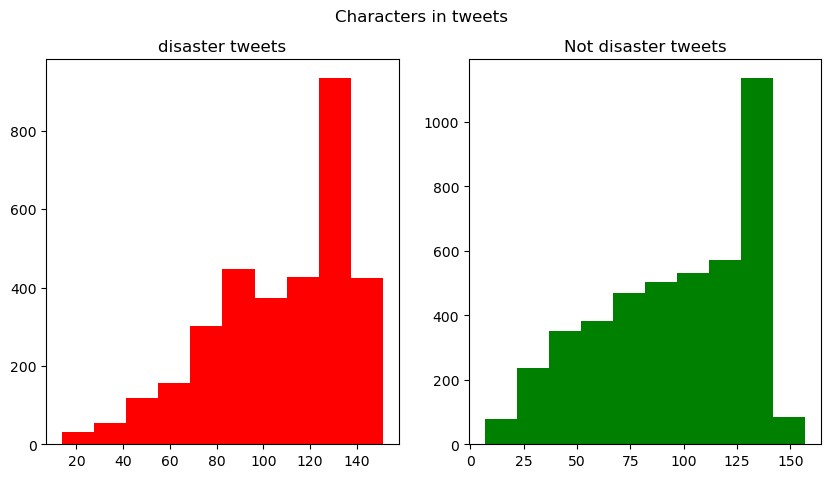

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
length_dis = df_train[df_train["target"]==1]["inputs"].apply(lambda x: len(x))
ax1.hist(len_dis,color='red')
ax1.set_title('disaster tweets')
length_nondis = df_train[df_train["target"]==0]["inputs"].apply(lambda x: len(x))
ax2.hist(len_nondis,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')

In [11]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [12]:
def preprocess_function(x): return tokenizer(x['inputs'])

In [13]:
keywords = df_train["keyword"].unique()
np.random.seed(4839)
np.random.shuffle(keywords)

In [14]:
val_prop = int(len(keywords)*0.25)
val_prop

55

In [15]:
val_kws = keywords[:val_prop]
val_kws.shape
val_idxs=df_train[df_train["keyword"].isin(val_kws)].index
trn_idxs=df_train[~df_train["keyword"].isin(val_kws)].index
len(val_idxs),len(trn_idxs)

(1917, 5696)

In [16]:
def get_dsd(df):
    ds = Dataset.from_pandas(df).rename_column("target", "labels")
    tkz_ds = ds.map(preprocess_function, batched = True)
    return DatasetDict({"train": tkz_ds.select(trn_idxs),"test": tkz_ds.select(val_idxs)})

In [17]:
dsd = get_dsd(df_train)
dsd

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'inputs', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5696
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'inputs', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1917
    })
})

In [18]:
def f1_metric(label,predc): return f1_score(label,predc)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) 
    return {'f1_metric': f1_metric(labels, predictions)}

In [19]:
def get_trainer(model,tkz_dsd):
    training_args = TrainingArguments(output_dir="my_model",learning_rate=lr,
    lr_scheduler_type='cosine', fp16=True,per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs,num_train_epochs=num_epochs,weight_decay=0.01,
    evaluation_strategy="epoch",report_to = "none")
    trainer = Trainer( model=model,args=training_args,train_dataset=tkz_dsd["train"],
    eval_dataset=tkz_dsd["test"],tokenizer=tokenizer,compute_metrics=compute_metrics)
    return trainer

In [20]:
def get_model(): 
    return AutoModelForSequenceClassification.from_pretrained(prtr_model,num_labels=2)

## Part 5 Model Refining

Based on the model we created in the earlier section we will refine it in this section. 

In [21]:
bs=16
lr=2e-6
num_epochs = 4

model_x = get_model()
trainer = get_trainer(model_x, dsd)
trainer.train()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Kenji\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Kenji\AppData\Local\Temp\ipykernel_23308\3304767789.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( model=model,args=training_args,train_dataset=tkz_dsd["train"],


Epoch,Training Loss,Validation Loss,F1 Metric
1,No log,0.680776,0.002288
2,0.678600,0.664077,0.318059
3,0.650400,0.640226,0.482861
4,0.650400,0.648495,0.444269


TrainOutput(global_step=1424, training_loss=0.6554409627164348, metrics={'train_runtime': 2197.9272, 'train_samples_per_second': 10.366, 'train_steps_per_second': 0.648, 'total_flos': 238561584395328.0, 'train_loss': 0.6554409627164348, 'epoch': 4.0})

In [22]:
df_test["inputs"] = df_test["text"].apply(lambda x: x.lower())
df_test


,id,keyword,location,text,inputs
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm in ri worse than last hurricane. my city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment in chicago http://t.co/u...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook (hwo) htt...


## Part 6 Results

In [23]:
eval = Dataset.from_pandas(df_test)
eval

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'inputs'],
    num_rows: 3263
})

In [24]:
tkz_eval_ds = eval.map(preprocess_function, batched=True)
tkz_eval_ds

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'inputs', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [25]:
pedictions_logits = trainer.predict(tkz_eval_ds)
pedictions_logits.predictions[1117:1122]

array([[ 0.51484   , -0.89692557],
       [ 0.35439435, -0.614802  ],
       [ 0.24885178, -0.39467427],
       [ 0.07847667, -0.01971813],
       [ 0.4631148 , -0.7797811 ]], dtype=float32)

In [26]:
predictions = trainer.predict(tkz_eval_ds).predictions.argmax(axis=1)

In [27]:
len(predictions)

3263

In [28]:
eval

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'inputs'],
    num_rows: 3263
})

## Part 7 Conclusion

Based on the results section we can confidently conclude that the model is able to analyze tweets and sort whether the input is a disasster tweet or not. 

## Part 8 Submission

This section creates the csv for submission. 

In [29]:
submission = datasets.Dataset.from_dict({
    'id': eval['id'],
    'target': predictions
})

submission.to_csv("C:/Users/Kenji/OneDrive/Documents/Intro to ML/Week 4/disasster_tweet_submission.csv", index=False)

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

26010